In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
from sklearn import tree, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import os

In [2]:
df_players = pd.read_csv('players.csv')
df_players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


In [3]:
df_games = pd.read_csv('games.csv')
df_games.head()

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr
0,2018090600,2018,1,09/06/2018,20:20:00,PHI,ATL
1,2018090900,2018,1,09/09/2018,13:00:00,BAL,BUF
2,2018090901,2018,1,09/09/2018,13:00:00,CLE,PIT
3,2018090902,2018,1,09/09/2018,13:00:00,IND,CIN
4,2018090903,2018,1,09/09/2018,13:00:00,MIA,TEN


In [4]:
df_plays = pd.read_csv('plays.csv')
df_plays.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,kickerId,...,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,passResult,kickLength,kickReturnYardage,playResult,absoluteYardlineNumber
0,2018090600,37,J.Elliott kicks 65 yards from PHI 35 to end zo...,1,0,0,PHI,Kickoff,Touchback,44966.0,...,NaN,NaN,NaN,0,0,NaN,66.0,NaN,40,45
1,2018090600,366,"(9:20) C.Johnston punts 56 yards to ATL 36, Ce...",1,4,4,PHI,Punt,Return,45603.0,...,UNSd,PHI 18,-15.0,0,0,NaN,56.0,5.0,36,18
2,2018090600,658,"(5:03) M.Bryant 21 yard field goal is GOOD, Ce...",1,4,3,ATL,Field Goal,Kick Attempt Good,27091.0,...,NaN,NaN,NaN,0,0,NaN,21.0,NaN,0,13
3,2018090600,677,M.Bosher kicks 64 yards from ATL 35 to PHI 1. ...,1,0,0,ATL,Kickoff,Return,37267.0,...,NaN,NaN,NaN,0,3,NaN,64.0,30.0,34,75
4,2018090600,872,"(:33) C.Johnston punts 65 yards to end zone, C...",1,4,18,PHI,Punt,Touchback,45603.0,...,NaN,NaN,NaN,0,3,NaN,65.0,NaN,45,45


In [5]:
df_scouting = pd.read_csv('PFFScoutingData.csv')
df_scouting.head()

,gameId,playId,snapDetail,snapTime,operationTime,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,gunners,puntRushers,specialTeamsSafeties,vises,kickContactType
0,2018090600,37,NaN,NaN,NaN,3.85,D,R,R,NaN,NaN,NaN,NaN,NaN,8-0-2,NaN,NaN,PHI 23; PHI 27,NaN,NaN
1,2018090600,366,OK,0.84,2.12,4.46,N,C,C,C,R,PHI 57,NaN,PHI 54,NaN,PHI 18; PHI 29,NaN,NaN,ATL 83; ATL 27; ATL 34; ATL 21,CC
2,2018090600,658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PHI 58,NaN,NaN
3,2018090600,677,NaN,NaN,NaN,4.06,D,R,R,C,C,ATL 83,ATL 22,ATL 27,8-0-2,NaN,NaN,ATL 17; ATL 22,NaN,NaN
4,2018090600,872,OK,0.84,2.00,4.35,N,C,L,NaN,NaN,NaN,NaN,NaN,NaN,PHI 18; PHI 29,ATL 85,ATL 37,ATL 83; ATL 34; ATL 21,BF


In [6]:
df_field_goal = df_plays[df_plays['specialTeamsPlayType'] == 'Field Goal']

In [7]:
df_field_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2657 entries, 2 to 19965
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gameId                  2657 non-null   int64  
 1   playId                  2657 non-null   int64  
 2   playDescription         2657 non-null   object 
 3   quarter                 2657 non-null   int64  
 4   down                    2657 non-null   int64  
 5   yardsToGo               2657 non-null   int64  
 6   possessionTeam          2657 non-null   object 
 7   specialTeamsPlayType    2657 non-null   object 
 8   specialTeamsResult      2657 non-null   object 
 9   kickerId                2643 non-null   float64
 10  returnerId              2 non-null      object 
 11  kickBlockerId           37 non-null     float64
 12  yardlineSide            2657 non-null   object 
 13  yardlineNumber          2657 non-null   int64  
 14  gameClock               2657 non-null  

In [8]:
columns = ['yardsToGo', 'yardlineNumber', 'kickLength', 'playResult', 'specialTeamsResult']
df = df_field_goal[columns]

In [9]:
df

,yardsToGo,yardlineNumber,kickLength,playResult,specialTeamsResult
2,3,3,21.0,0,Kick Attempt Good
6,8,8,26.0,0,Kick Attempt Good
8,17,34,52.0,0,Kick Attempt Good
33,13,23,41.0,0,Kick Attempt Good
36,9,34,52.0,-8,Kick Attempt No Good
...,...,...,...,...,...
19952,10,17,36.0,0,Kick Attempt Good
19955,3,12,30.0,0,Kick Attempt Good
19959,6,18,36.0,0,Kick Attempt Good
19962,8,29,47.0,0,Kick Attempt Good


In [10]:
x = df.dropna()
x['specialTeamsResult'] = x['specialTeamsResult'].apply(lambda x: 1 if str(x) in 'Kick Attempt Good' else 0)

In [11]:
x

,yardsToGo,yardlineNumber,kickLength,playResult,specialTeamsResult
2,3,3,21.0,0,1
6,8,8,26.0,0,1
8,17,34,52.0,0,1
33,13,23,41.0,0,1
36,9,34,52.0,-8,0
...,...,...,...,...,...
19952,10,17,36.0,0,1
19955,3,12,30.0,0,1
19959,6,18,36.0,0,1
19962,8,29,47.0,0,1


In [12]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

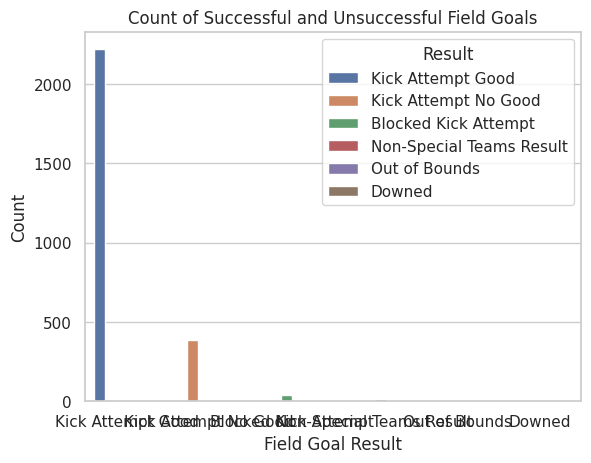

In [13]:
ax = sns.countplot(data=df_field_goal, x="specialTeamsResult", hue="specialTeamsResult")
ax.set(title="Count of Successful and Unsuccessful Field Goals")
ax.set_xlabel("Field Goal Result")
ax.set_ylabel("Count")
ax.legend(title="Result")

plt.show()

In [14]:
y = x['specialTeamsResult']
X_train, X_test, y_train, y_test = train_test_split(x.drop(columns=['specialTeamsResult'], axis=1), y, test_size=0.3)

In [15]:
ad_clf = AdaBoostClassifier()
knearest_clf = KNeighborsClassifier()
svc_clf = SVC(kernel="linear", class_weight='balanced')
xgboost_clf = XGBClassifier(scale_pos_weight=5)
rndm_frst = RandomForestClassifier(n_estimators=100, class_weight="balanced")

In [16]:
classifiers = [ad_clf, knearest_clf, svc_clf, rndm_frst, xgboost_clf]

def run_classifier_models(cls_models, X_train, y_train, X_test, y_test):
    for clsfr in cls_models:
        clf = make_pipeline(StandardScaler(), clsfr)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print('score for ', clsfr.__class__.__name__, score)
        if "SVC" not in clsfr.__class__.__name__:
            print('roc auc score', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
        print(
            f"Classification report for classifier {clf}:\n"
            f"{classification_report(y_test, clf.predict(X_test))}\n"
        )

run_classifier_models(classifiers, X_train, y_train, X_test, y_test)

score for  AdaBoostClassifier 1.0
roc auc score 1.0
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier', AdaBoostClassifier())]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       120
           1       1.00      1.00      1.00       662

    accuracy                           1.00       782
   macro avg       1.00      1.00      1.00       782
weighted avg       1.00      1.00      1.00       782


score for  KNeighborsClassifier 0.9987212276214834
roc auc score 0.9958333333333333
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]):
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       120
           1       1.00      1.00      1.00       662

    accuracy                           1.00       782
   m

In [17]:
df_majority = x[x.specialTeamsResult==1]
df_minority = x[x.specialTeamsResult==0]

num_samples = 2218

df_minority_upsampled = resample(df_minority, replace=True, n_samples=num_samples)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

df_upsampled.specialTeamsResult.value_counts()

1    2218
0    2218
Name: specialTeamsResult, dtype: int64

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

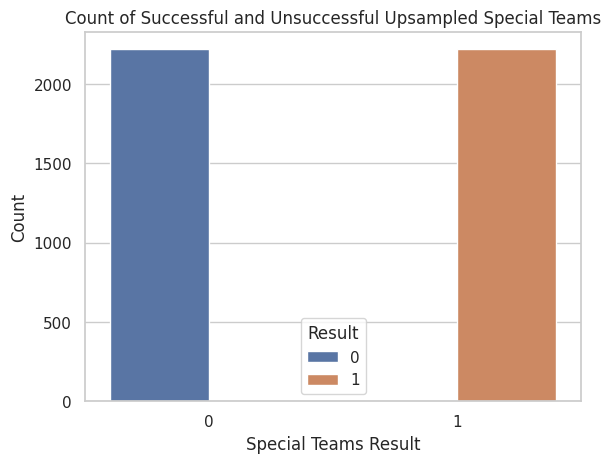

In [19]:
ax = sns.countplot(data=df_upsampled, x="specialTeamsResult", hue="specialTeamsResult")
ax.set(title="Count of Successful and Unsuccessful Upsampled Special Teams")
ax.set_xlabel("Special Teams Result")
ax.set_ylabel("Count")
ax.legend(title="Result")

plt.show()

In [20]:
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(df_upsampled.drop(columns=['specialTeamsResult'], axis=1), df_upsampled['specialTeamsResult'], test_size=0.3)

In [21]:
run_classifier_models(classifiers, X_scaled_train, y_scaled_train, X_scaled_test, y_scaled_test)

score for  AdaBoostClassifier 1.0
roc auc score 1.0
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('adaboostclassifier', AdaBoostClassifier())]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       680
           1       1.00      1.00      1.00       651

    accuracy                           1.00      1331
   macro avg       1.00      1.00      1.00      1331
weighted avg       1.00      1.00      1.00      1331


score for  KNeighborsClassifier 1.0
roc auc score 1.0
Classification report for classifier Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())]):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       680
           1       1.00      1.00      1.00       651

    accuracy                           1.00      1331
   macro avg       1.00      1.00 

In [22]:
a = df_plays['possessionTeam'].str.count('PHI')
b = df_plays['specialTeamsPlayType'].str.count('Kickoff')
c = df_plays['specialTeamsResult'].str.count('Touchback')

In [23]:
y_true = pd.concat([a,b,c])
y_true.head()

0    1
1    1
2    0
3    0
4    1
dtype: int64

In [24]:
a1 = df_plays['possessionTeam'].str.count('PHI')
b1 = df_plays['specialTeamsPlayType'].str.count('Field Goal')
c1 = df_plays['specialTeamsResult'].str.count('Kick Attempt Good')

In [25]:
y_true1 = pd.concat([a1,b1,c1])
y_true1.head()

0    1
1    1
2    0
3    0
4    1
dtype: int64

In [26]:
a2 = df_plays['possessionTeam'].str.count('PHI')
b2 = df_plays['specialTeamsPlayType'].str.count('')
c2 = df_plays['specialTeamsResult'].str.count('')

In [27]:
y_pred = pd.concat([a2, b2, c2])
y_pred.head()

0    1
1    1
2    0
3    0
4    1
dtype: int64

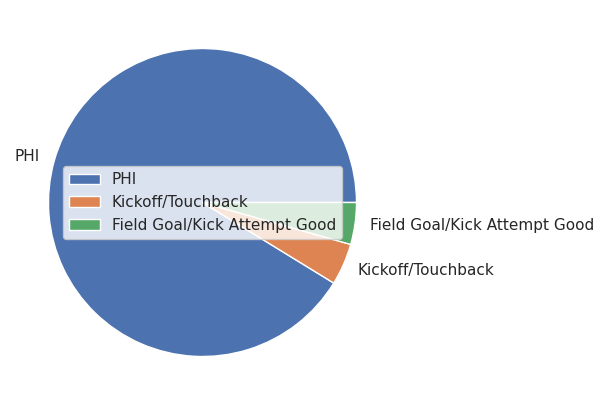

In [28]:
df = pd.DataFrame({'': [1,f1_score(y_true, y_pred, average='macro'),f1_score(y_true1, y_pred, average='macro')]},
                  index=['PHI','Kickoff/Touchback','Field Goal/Kick Attempt Good'])

plot = df.plot.pie(y='', figsize=(5, 5))

In [29]:
f1_score(y_true, y_pred, average='macro'), f1_score(y_true1, y_pred, average='macro')

(0.0479627414765748, 0.048108817963346824)

In [30]:
a = df_plays['possessionTeam'].str.count('BUF')
b = df_plays['specialTeamsPlayType'].str.count('Punt')
c = df_plays['specialTeamsResult'].str.count('Out of Bounds')

In [31]:
y_true = pd.concat([a,b,c])

In [32]:
a1 = df_plays['possessionTeam'].str.count('PHI')
b1 = df_plays['specialTeamsPlayType'].str.count('')
c1 = df_plays['specialTeamsResult'].str.count('')

In [33]:
y_pred  = pd.concat([a1,b1,c1])

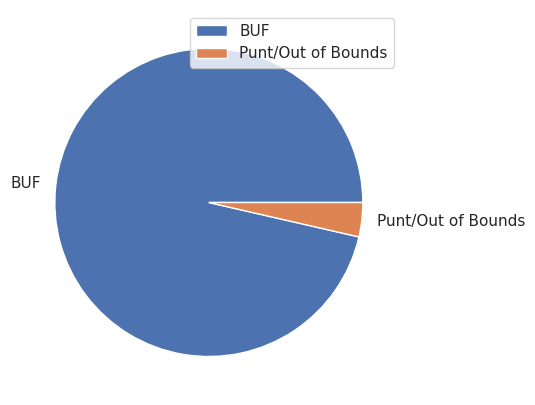

In [34]:
df = pd.DataFrame({'': [1,f1_score(y_true, y_pred, average='macro')]},index=['BUF', 'Punt/Out of Bounds'])
plot = df.plot.pie(y='', figsize=(5, 5))

In [35]:
f1_score(y_true, y_pred, average='macro')

0.03721140446687508

In [36]:
a = df_plays['possessionTeam'].str.count('ATL')
b = df_plays['specialTeamsPlayType'].str.count('Punt')
c = df_plays['specialTeamsResult'].str.count('')

In [37]:
y_true = pd.concat([a,b,c])

In [38]:
a1 = df_plays['possessionTeam'].str.count('ATL')
b1 = df_plays['specialTeamsPlayType'].str.count('')
c1 = df_plays['specialTeamsResult'].str.count('')

In [39]:
y_pred = pd.concat([a1,b1,c1])

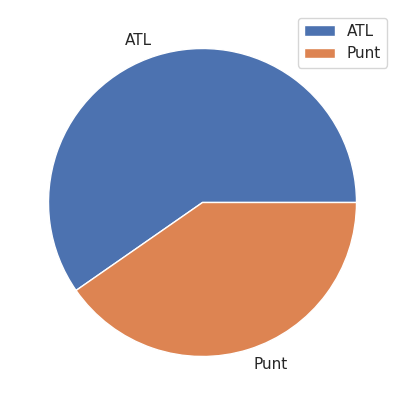

In [40]:
df = pd.DataFrame({'': [1,f1_score(y_true, y_pred, average='macro')]},index=['ATL', 'Punt'])
plot = df.plot.pie(y='', figsize=(5, 5))

In [41]:
f1_score(y_true, y_pred, average='macro')

0.6757741252503106

In [42]:
df_plays['possessionTeam'].str.count('ATL')

0        0
1        0
2        1
3        1
4        0
        ..
19974    0
19975    0
19976    0
19977    0
19978    0
Name: possessionTeam, Length: 19979, dtype: int64

In [43]:
df_plays['possessionTeam']. value_counts(), df_plays['specialTeamsPlayType']. value_counts(),df_plays['specialTeamsResult']. value_counts()

(BAL    682
 NO     682
 LA     676
 TB     672
 KC     659
 GB     653
 NE     652
 HOU    648
 SEA    648
 IND    637
 TEN    637
 PIT    636
 BUF    631
 ATL    627
 MIA    625
 CHI    621
 DET    618
 ARI    618
 NYJ    616
 DAL    613
 CLE    610
 SF     606
 LAC    604
 CIN    601
 DEN    598
 NYG    593
 CAR    587
 MIN    584
 WAS    582
 JAX    579
 PHI    576
 OAK    394
 LV     214
 Name: possessionTeam, dtype: int64,
 Kickoff        7843
 Punt           5991
 Extra Point    3488
 Field Goal     2657
 Name: specialTeamsPlayType, dtype: int64,
 Kick Attempt Good           5470
 Return                      5207
 Touchback                   5156
 Fair Catch                  1645
 Downed                       834
 Out of Bounds                651
 Kick Attempt No Good         585
 Muffed                       214
 Non-Special Teams Result     101
 Blocked Kick Attempt          61
 Blocked Punt                  39
 Kickoff Team Recovery         16
 Name: specialTeamsResult, dtype

In [44]:
df_scouting.columns

Index(['gameId', 'playId', 'snapDetail', 'snapTime', 'operationTime',
       'hangTime', 'kickType', 'kickDirectionIntended', 'kickDirectionActual',
       'returnDirectionIntended', 'returnDirectionActual', 'missedTackler',
       'assistTackler', 'tackler', 'kickoffReturnFormation', 'gunners',
       'puntRushers', 'specialTeamsSafeties', 'vises', 'kickContactType'],
      dtype='object')

In [45]:
df_scouting = df_scouting[['gameId', 'hangTime', 'operationTime', 'kickType', 'kickDirectionIntended', 'kickDirectionActual']]

In [46]:
df_scouting.duplicated().sum()

5820

In [47]:
df_scouting.drop_duplicates(inplace=True)

In [48]:
print("data shape:", df_scouting.shape)
df_scouting.isna().sum()

data shape: (14159, 6)


gameId                      0
hangTime                 1372
operationTime            8242
kickType                  801
kickDirectionIntended     823
kickDirectionActual       823
dtype: int64

In [49]:
df_scouting.dropna(axis=0, inplace=True)

In [50]:
df_scouting.head(3)

,gameId,hangTime,operationTime,kickType,kickDirectionIntended,kickDirectionActual
1,2018090600,4.46,2.12,N,C,C
4,2018090600,4.35,2.00,N,C,L
5,2018090600,4.98,2.19,N,L,L


In [51]:
df_plays.columns

Index(['gameId', 'playId', 'playDescription', 'quarter', 'down', 'yardsToGo',
       'possessionTeam', 'specialTeamsPlayType', 'specialTeamsResult',
       'kickerId', 'returnerId', 'kickBlockerId', 'yardlineSide',
       'yardlineNumber', 'gameClock', 'penaltyCodes', 'penaltyJerseyNumbers',
       'penaltyYards', 'preSnapHomeScore', 'preSnapVisitorScore', 'passResult',
       'kickLength', 'kickReturnYardage', 'playResult',
       'absoluteYardlineNumber'],
      dtype='object')

In [52]:
df_plays = df_plays[['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'specialTeamsPlayType',
              'specialTeamsResult', 'playResult']]

In [53]:
df_plays.head(3)

,gameId,playId,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,playResult
0,2018090600,37,1,0,0,PHI,Kickoff,Touchback,40
1,2018090600,366,1,4,4,PHI,Punt,Return,36
2,2018090600,658,1,4,3,ATL,Field Goal,Kick Attempt Good,0


In [54]:
df_scouting['kickType'].unique()

array(['N', 'A', 'R'], dtype=object)

In [55]:
df_scouting['kickType'] = df_scouting['kickType'].map({'N':'standard punt style', 'A':'Aussie-style punts', 'R':'Rugby style punt'})

In [56]:
df_scouting['kickType'].value_counts()

standard punt style    4079
Aussie-style punts     1780
Rugby style punt          4
Name: kickType, dtype: int64

In [57]:
px.bar(df_scouting['kickType'].value_counts(), title='Most frequent kick types', labels={'index':'style', 'value':'count'})

In [58]:
df_scouting[df_scouting['kickDirectionActual']!=df_scouting['kickDirectionIntended']].shape[0]

191

In [59]:
Actual_Intend_direction = pd.pivot_table(data=df_scouting, index=['kickDirectionIntended'],
                                         columns='kickDirectionActual', values='gameId', aggfunc='count').fillna(0)

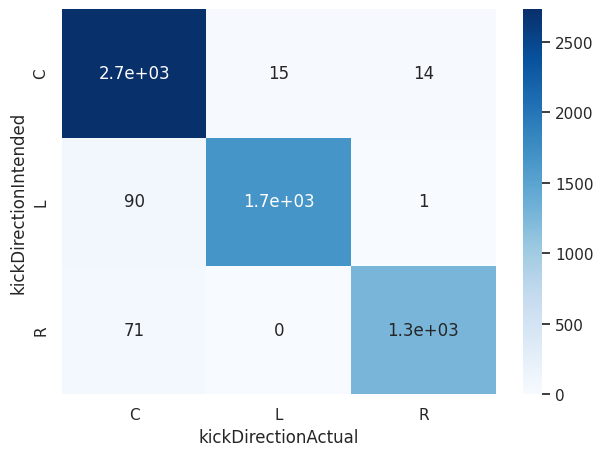

In [60]:
plt.figure(figsize=(7,5))
sns.heatmap(Actual_Intend_direction, cmap='Blues', annot=True);

In [61]:
px.scatter(data_frame=df_scouting, x='operationTime', y='hangTime', marginal_x='histogram', marginal_y='histogram')

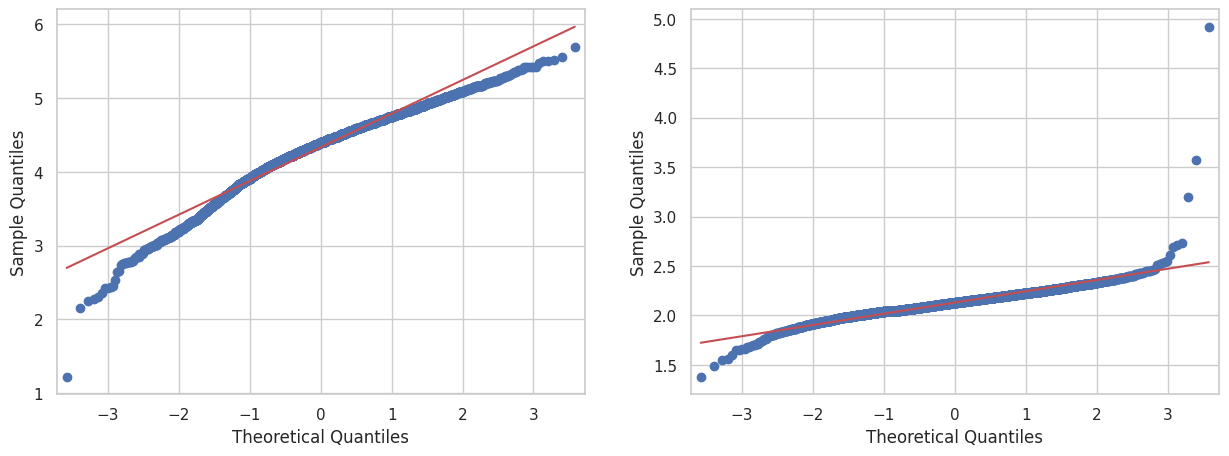

In [62]:
plt.figure(figsize=(15,5))

x1 = plt.subplot(1, 2, 1)
q1 = qqplot(df_scouting['hangTime'], line='s',ax = x1)

x2 = plt.subplot(1, 2, 2)
q2 = qqplot(df_scouting['operationTime'], line='s',ax = x2)

In [63]:
df_plays.head()

,gameId,playId,quarter,down,yardsToGo,possessionTeam,specialTeamsPlayType,specialTeamsResult,playResult
0,2018090600,37,1,0,0,PHI,Kickoff,Touchback,40
1,2018090600,366,1,4,4,PHI,Punt,Return,36
2,2018090600,658,1,4,3,ATL,Field Goal,Kick Attempt Good,0
3,2018090600,677,1,0,0,ATL,Kickoff,Return,34
4,2018090600,872,1,4,18,PHI,Punt,Touchback,45


In [64]:
px.bar(df_plays['quarter'].value_counts(), width=700, height=500, title='No. of plays each quarter', labels={'index':'quarter', 'value':'count'})

In [65]:
px.bar(df_plays['down'].value_counts(), width=700, height=500, title='No. of plays each down', labels={'index':'down', 'value':'count'})

In [66]:
df_plays['playResult'].describe()

count    19979.000000
mean        27.315932
std         20.556990
min        -72.000000
25%          0.000000
50%         39.000000
75%         40.000000
max         82.000000
Name: playResult, dtype: float64

In [67]:
px.histogram(df_plays['playResult'], width=1200, height=600)

In [68]:
top_ten = df_plays['possessionTeam'].value_counts()[:10]
top_ten

BAL    682
NO     682
LA     676
TB     672
KC     659
GB     653
NE     652
HOU    648
SEA    648
IND    637
Name: possessionTeam, dtype: int64

In [69]:
px.bar(top_ten, width=1000, height=600, orientation='h', title='No. of plays each possessionTeam', labels={'index':'possessionTeam', 'value':'count'})

In [70]:
count = df_plays['specialTeamsPlayType'].value_counts()
count

Kickoff        7843
Punt           5991
Extra Point    3488
Field Goal     2657
Name: specialTeamsPlayType, dtype: int64

In [71]:
px.pie(names=count.index, values=count, title='Special teams --- play type')

In [72]:
df_players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


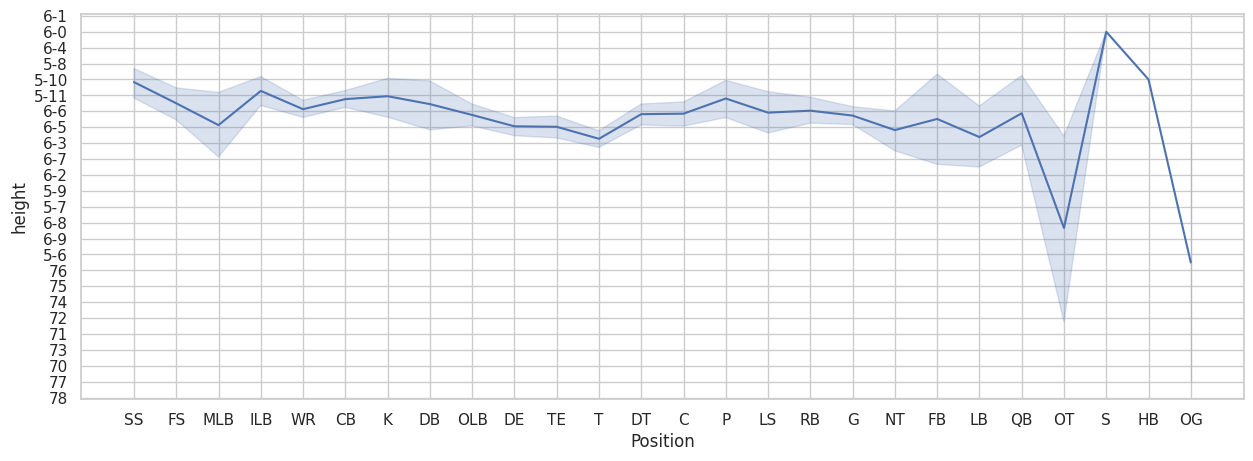

In [73]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_players, x='Position', y='height');

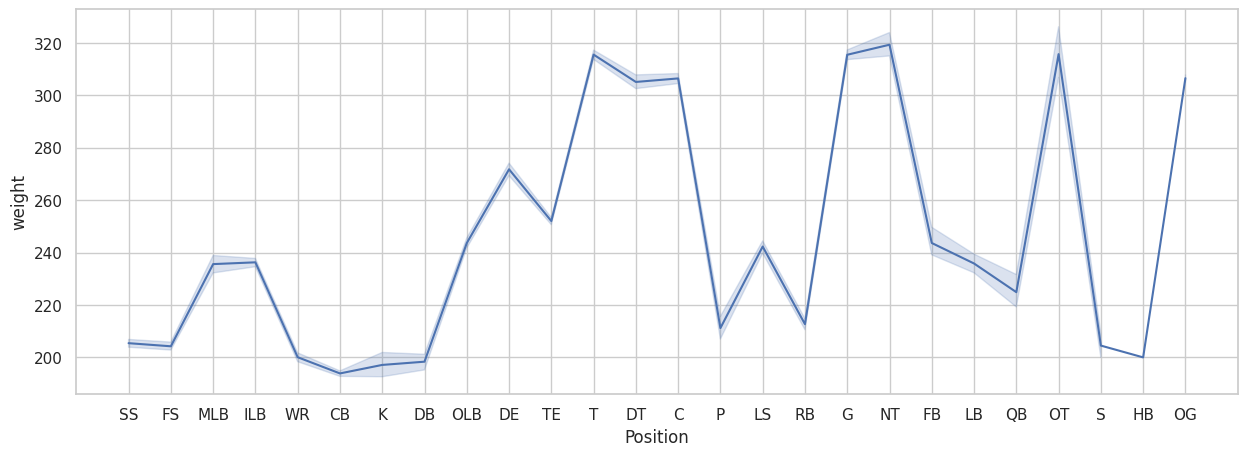

In [74]:
plt.figure(figsize=(15,5))
sns.lineplot(data=df_players, x='Position', y='weight');

In [75]:
df_players['height'].describe()

count     2732
unique      30
top        6-3
freq       367
Name: height, dtype: object

In [76]:
print("NFL seasons and count for each year:")
games_per_season = df_games.pivot_table(index = ['season'], aggfunc = 'size')
games_per_season = games_per_season.reset_index()
games_per_season.columns= ["Seasons", "Count"]
games_per_season = games_per_season.sort_values("Count", ascending = False)
print(games_per_season)

NFL seasons and count for each year:
   Seasons  Count
2     2020    256
1     2019    255
0     2018    253


In [77]:
px.bar(games_per_season, x="Seasons", y="Count", title="NFL Seasons", color="Seasons")

In [78]:
df_games['gameYear'] = pd.DatetimeIndex(df_games['gameDate']).year
print(df_games["gameYear"])

0      2018
1      2018
2      2018
3      2018
4      2018
       ... 
759    2021
760    2021
761    2021
762    2021
763    2021
Name: gameYear, Length: 764, dtype: int64


In [79]:
print("number of games per year: ")
games_per_year = df_games.pivot_table(index = ['gameYear'], aggfunc = 'size')
games_per_year = games_per_year.reset_index()
games_per_year.columns= ["Year", "Count"]
games_per_year = games_per_year.sort_values("Count", ascending = False)
print(games_per_year)

number of games per year: 
   Year  Count
1  2019    255
0  2018    253
2  2020    240
3  2021     16


In [80]:
px.bar(games_per_year, x="Year", y="Count", title="No. of games per year", color="Year")

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

In [82]:
df_players = pd.read_csv('players.csv')
df_players.head()

,nflId,height,weight,birthDate,collegeName,Position,displayName
0,42901,6-1,208,1992-07-25,James Madison,SS,Dean Marlowe
1,43501,6-0,220,1994-08-11,Central Michigan,FS,Kavon Frazier
2,43534,6-0,205,1993-06-02,Illinois,SS,Clayton Fejedelem
3,43535,6-1,235,1992-12-22,Temple,MLB,Tyler Matakevich
4,44174,6-1,236,1993-02-22,Texas Tech,ILB,Sam Eguavoen


In [83]:
df_players = df_players.dropna(subset=['Position'])

In [84]:
def convert_height(height_str):
    try:
        if '-' in height_str:
            feet, inches = map(int, height_str.split('-'))
            return feet * 12 + inches
        elif "'" in height_str:
            inches = int(height_str.strip("'"))
            return inches
        else:
            return int(height_str)
    except:
        return None

df_players['height'] = df_players['height'].apply(convert_height)

In [85]:
df_players = df_players.dropna(subset=['height'])

In [86]:
features = df_players[['height', 'weight']]
target = df_players['Position']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [88]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [89]:
rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [90]:
best_rf_classifier = grid_search.best_estimator_

In [91]:
cv_scores = cross_val_score(best_rf_classifier, features, target, cv=5)
mean_cv_score = cv_scores.mean()

In [92]:
y_pred = best_rf_classifier.predict(X_test)
classification_rep = classification_report(y_test, y_pred)

In [93]:
print("Cross-Validation Mean Score:", mean_cv_score)
print("Classification Report:\n", classification_rep)

Cross-Validation Mean Score: 0.41801300466748365
Classification Report:
               precision    recall  f1-score   support

           C       0.43      0.16      0.23        19
          CB       0.46      0.63      0.54        60
          DB       0.00      0.00      0.00         6
          DE       0.54      0.59      0.56        46
          DT       0.39      0.44      0.41        32
          FB       0.00      0.00      0.00         5
          FS       0.43      0.21      0.29        28
           G       0.33      0.46      0.38        28
          HB       0.00      0.00      0.00         1
         ILB       0.42      0.52      0.47        27
           K       0.00      0.00      0.00        10
          LB       0.00      0.00      0.00        11
          LS       0.00      0.00      0.00         9
         MLB       0.00      0.00      0.00         5
          NT       0.33      0.07      0.11        15
         OLB       0.30      0.33      0.31        40
        